# PROJECT FOR DATABASE & ANALYTICS PROGRAMMING
### POSTGRADUATE IN SCIENCE IN DATA ANALYTICS
### NATIONAL COLLEGE OF IRELAND
### AUTHOR: JORDI BATLLE LALANDE

####################################################################################################
## ASHRAE - Great Energy Predictor III
#### How much energy will a building consume?
#### Data retrieved from Kaggle: https://www.kaggle.com/c/ashrae-energy-prediction
####################################################################################################

### LIBRARIES AND SETTINGS

In [1]:
# Set the notebook to avoid having to explicit the print command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Extract the files from the Zip downloaded from Kaggle
from zipfile import ZipFile

# To access computer folders
import os

# Termcolor for print output format
from termcolor import colored

# Pandas for data wrangling and output set-up 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' %x)

# for stats calcs
import numpy as np
from scipy.stats import pearsonr

# Create table output
from prettytable import PrettyTable

# Plot libraries and set-up
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sb
%matplotlib inline
plt.rcParams['font.family'] = "serif"
sb.set_style('whitegrid')
from matplotlib import pyplot

# Garbage collect to free memory
import gc
gc.enable()

# Machine learning libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

C:\Users\jordi\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
C:\Users\jordi\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### FUNCTIONS DEFINITION

In [2]:
# Function to format print calls
def Text(s):
    print(colored("#"*50, 'blue', attrs=['bold']))
    print(colored(s, 'blue', attrs=['bold']))
    print(colored("#"*50, 'blue', attrs=['bold']))

# Function to count the number of records in dataframe
def Records(df):
    return len(df.index)

# Function to run basic data frame descriptives
def Descriptives(df):
    print("Looking at the shape to see the number of records:")
    print(df.shape)    
    print("\nSampling the first and last rows of data:")
    print(df.head())
    print(df.tail())
    print("\nDescription of the file to check values range:")
    print(df.describe().transpose())
    print("\nAttributes and respective data types:")    
    print(df.info(memory_usage='deep'))
    
# Function to check the memory used by the data frame
def MemUsage(df):
    print("Amount of memory used by each attribute:")
    print(df.memory_usage(deep=True))
    Mem = df.memory_usage(deep=True).sum()
    return Mem

# Function to check the missing values (NaNs)
def Missing(df):
    try:
        assert df.notnull().all().all()
        print(colored("Good news! There are no missing values.", attrs=['bold']))
    
    except AssertionError:
        print("Amount of missing values:")
        print(df.isna().sum())
        print("\nPercentage of missing values:")
        print(df.isna().mean().round(4)*100, "\n")

### READ ZIPPED FILES

In [3]:
# Extract files from our ZipFile and save in the input folder
with ZipFile('ashrae-energy-prediction.zip', 'r') as zipObj:
    # Get a list of all archived file names from the zip
    files = zipObj.namelist()
    # Iterate over the file names
    for fileName in files:
        # Check filename endswith csv
        if fileName.endswith('.csv'):
            # Extract csv files and save in input folder for later use
            zipObj.extract(fileName)

'C:\\Users\\jordi\\Desktop\\Github\\Ashrae\\building_metadata.csv'

'C:\\Users\\jordi\\Desktop\\Github\\Ashrae\\train.csv'

'C:\\Users\\jordi\\Desktop\\Github\\Ashrae\\weather_train.csv'

In [4]:
del zipObj, files, fileName
gc.collect()

48

### EXPLORE THE FILES

In [5]:
Text("1/ BUILDING DATAFRAME PREPROCESSING")

##################################################
1/ BUILDING DATAFRAME PREPROCESSING
##################################################


In [6]:
# Read the csv file
building = pd.read_csv('building_metadata.csv')

In [7]:
# Run basic description of the dataframe
Descriptives(building)

Looking at the shape to see the number of records:
(1449, 6)

Sampling the first and last rows of data:
   site_id  building_id primary_use  square_feet  year_built  floor_count
0  0        0            Education   7432        2008.000    nan         
1  0        1            Education   2720        2004.000    nan         
2  0        2            Education   5376        1991.000    nan         
3  0        3            Education   23685       2002.000    nan         
4  0        4            Education   116607      1975.000    nan         
      site_id  building_id                    primary_use  square_feet  year_built  floor_count
1444  15       1444         Entertainment/public assembly  19619       1914.000    nan         
1445  15       1445         Education                      4298        nan         nan         
1446  15       1446         Entertainment/public assembly  11265       1997.000    nan         
1447  15       1447         Lodging/residential            29775    

In [8]:
# Check the memory used by each attribute
MemUsage(building)     

Amount of memory used by each attribute:
Index          128   
site_id        11592 
building_id    11592 
primary_use    101138
square_feet    11592 
year_built     11592 
floor_count    11592 
dtype: int64


159226

In [9]:
# Check the missing values
Missing(building)

Amount of missing values:
site_id        0   
building_id    0   
primary_use    0   
square_feet    0   
year_built     774 
floor_count    1094
dtype: int64

Percentage of missing values:
site_id       0.000 
building_id   0.000 
primary_use   0.000 
square_feet   0.000 
year_built    53.420
floor_count   75.500
dtype: float64 



In [10]:
# Missing values: drop the attributes floor_count and year_built which have 75% and 53% of NaN)
# and don't bring value to the analysis
building = building.drop(columns=['floor_count', 'year_built'])

In [11]:
# Check no missing values left:
Missing(building)

Good news! There are no missing values.


In [12]:
# Downcast attributes in order to free memory
building['site_id'] = pd.to_numeric(building['site_id'], downcast='unsigned')
building['building_id'] = pd.to_numeric(building['building_id'], downcast='unsigned')
building['primary_use'] = building.primary_use.astype('category')
building['square_feet'] = building.square_feet.astype('uint32')

In [13]:
# Re-check memory usage
MemUsage(building)     

Amount of memory used by each attribute:
Index          128 
site_id        1449
building_id    2898
primary_use    3220
square_feet    5796
dtype: int64


13491

In [14]:
# Check values range in primary_use variable
building['primary_use'].unique()

['Education', 'Lodging/residential', 'Office', 'Entertainment/public assembly', 'Other', ..., 'Healthcare', 'Utility', 'Technology/science', 'Manufacturing/industrial', 'Services']
Length: 16
Categories (16, object): ['Education', 'Lodging/residential', 'Office', 'Entertainment/public assembly', ..., 'Utility', 'Technology/science', 'Manufacturing/industrial', 'Services']

In [15]:
# Recode longer strings to facilitate plottings and check the results
dict = {'Lodging/residential':'Residential', 'Entertainment/public assembly':'Entertainment',
        'Warehouse/storage':'Warehouse', 'Food sales and service':'Food', 'Religious worship':'Worship',
        'Technology/science':'Technology', 'Manufacturing/industrial':'Industrial'}
building = building.replace({'primary_use': dict})
building['primary_use'].unique()

array(['Education', 'Residential', 'Office', 'Entertainment', 'Other',
       'Retail', 'Parking', 'Public services', 'Warehouse', 'Food',
       'Worship', 'Healthcare', 'Utility', 'Technology', 'Industrial',
       'Services'], dtype=object)

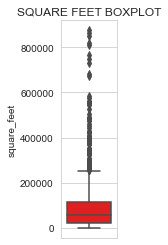

In [16]:
# Check for outliers
# Create boxplot for square_feet variable
rcParams['figure.figsize'] = 1, 4
sb.boxplot(y='square_feet', data=building, color='red').set_title('SQUARE FEET BOXPLOT')
plt.show();

In [17]:
# Check values out of range with different tresholds as per boxplot values
table = PrettyTable(header_style='upper', padding_width=2, field_names = ["Threshold (sq.f)", "Count", "Percentage"])
for i in [250000, 400000, 600000, 800000]:
    ct = building.square_feet[building.square_feet > i].count()
    ttl = building.square_feet.count()
    pct = round((ct/ttl)*100, 1)
    row= i, ct, pct
    table.add_row(row)
table.align = "r"
print(table)

+--------------------+---------+--------------+
|  THRESHOLD (SQ.F)  |  COUNT  |  PERCENTAGE  |
+--------------------+---------+--------------+
|            250000  |    108  |         7.5  |
|            400000  |     34  |         2.3  |
|            600000  |     10  |         0.7  |
|            800000  |      5  |         0.3  |
+--------------------+---------+--------------+


In [18]:
# Outlier values are realistic but extreme values would bias ML models: eliminate building over 400,000 sq.f.
building = building[building.square_feet < 400000]

In [19]:
# Finally
print(colored("BUILDING TRAIN DATAFRAME CLEANED UP", attrs=['bold']))
Descriptives(building)

BUILDING TRAIN DATAFRAME CLEANED UP
Looking at the shape to see the number of records:
(1414, 4)

Sampling the first and last rows of data:
   site_id  building_id primary_use  square_feet
0  0        0            Education   7432       
1  0        1            Education   2720       
2  0        2            Education   5376       
3  0        3            Education   23685      
4  0        4            Education   116607     
      site_id  building_id    primary_use  square_feet
1444  15       1444         Entertainment  19619      
1445  15       1445         Education      4298       
1446  15       1446         Entertainment  11265      
1447  15       1447         Residential    29775      
1448  15       1448         Office         92271      

Description of the file to check values range:
               count      mean       std     min       25%       50%        75%        max
site_id     1414.000 6.962     5.026     0.000   3.000     5.000     13.000     15.000    
buildi

In [20]:
del dict, table, i, row, ct, ttl, pct
gc.collect()

2483

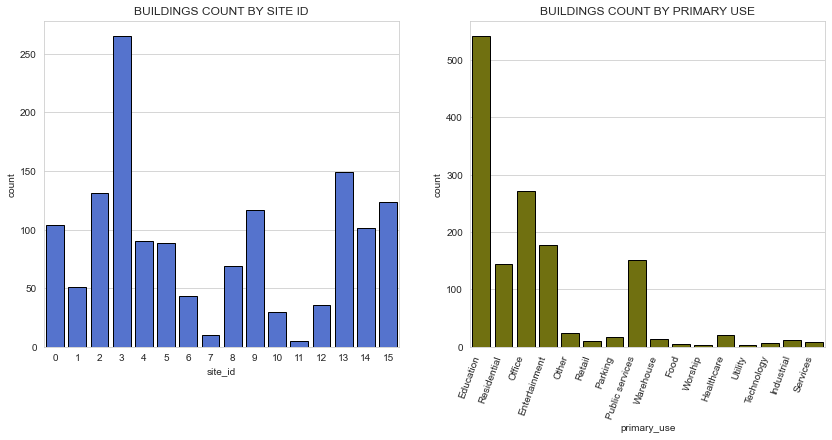

In [21]:
# Create bar plots to see data distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sb.countplot(data=building, x = 'site_id', ax=axes[0], color='royalblue',
             edgecolor='black',linewidth=1).set_title('BUILDINGS COUNT BY SITE ID')

sb.countplot(data=building, x = 'primary_use', ax=axes[1], color='olive', 
             edgecolor='black',linewidth=1).set_title('BUILDINGS COUNT BY PRIMARY USE')
plt.xticks(
    rotation=70, 
    horizontalalignment='right');

In [22]:
Text("2/ WEATHER DATAFRAME PREPROCESSING")

##################################################
2/ WEATHER DATAFRAME PREPROCESSING
##################################################


In [23]:
# Read the csv file
weather = pd.read_csv('weather_train.csv')

In [24]:
# Run basic description of the dataframe
Descriptives(weather)

Looking at the shape to see the number of records:
(139773, 9)

Sampling the first and last rows of data:
   site_id            timestamp  air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  wind_speed
0  0        2016-01-01 00:00:00 25.000           6.000           20.000           nan                1019.700            0.000           0.000      
1  0        2016-01-01 01:00:00 24.400           nan             21.100           -1.000             1020.200            70.000          1.500      
2  0        2016-01-01 02:00:00 22.800           2.000           21.100           0.000              1020.200            0.000           0.000      
3  0        2016-01-01 03:00:00 21.100           2.000           20.600           0.000              1020.100            0.000           0.000      
4  0        2016-01-01 04:00:00 20.000           2.000           20.000           -1.000             1020.000            250.000         2.600      


In [25]:
# Check the memory used by each attribute
MemUsage(weather)    

Amount of memory used by each attribute:
Index                 128     
site_id               1118184 
timestamp             10622748
air_temperature       1118184 
cloud_coverage        1118184 
dew_temperature       1118184 
precip_depth_1_hr     1118184 
sea_level_pressure    1118184 
wind_direction        1118184 
wind_speed            1118184 
dtype: int64


19568348

In [26]:
# Downcast attributes in order to free memory
weather["timestamp"] = pd.to_datetime(weather["timestamp"])
weather['site_id'] = pd.to_numeric(weather['site_id'], downcast='unsigned')
weather['air_temperature'] = pd.to_numeric(weather['air_temperature'], downcast='float')
weather['cloud_coverage'] = pd.to_numeric(weather['cloud_coverage'], downcast='float')
weather['dew_temperature'] = pd.to_numeric(weather['dew_temperature'], downcast='float')
weather['precip_depth_1_hr'] = pd.to_numeric(weather['precip_depth_1_hr'], downcast='float')
weather['sea_level_pressure'] = pd.to_numeric(weather['sea_level_pressure'], downcast='float')
weather['wind_direction'] = pd.to_numeric(weather['wind_direction'], downcast='float')
weather['wind_speed'] = pd.to_numeric(weather['wind_speed'], downcast='float')

In [27]:
# Re-check the memory usage
MemUsage(weather) 

Amount of memory used by each attribute:
Index                 128    
site_id               139773 
timestamp             1118184
air_temperature       559092 
cloud_coverage        559092 
dew_temperature       559092 
precip_depth_1_hr     559092 
sea_level_pressure    559092 
wind_direction        559092 
wind_speed            559092 
dtype: int64


5171729

In [28]:
# Check the missing values NaN
Missing(weather)

Amount of missing values:
site_id               0    
timestamp             0    
air_temperature       55   
cloud_coverage        69173
dew_temperature       113  
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction        6268 
wind_speed            304  
dtype: int64

Percentage of missing values:
site_id              0.000 
timestamp            0.000 
air_temperature      0.040 
cloud_coverage       49.490
dew_temperature      0.080 
precip_depth_1_hr    35.980
sea_level_pressure   7.600 
wind_direction       4.480 
wind_speed           0.220 
dtype: float64 



In [29]:
# I consider variables with NaN important so will be replaced with means
# Check for outliers (dealing with outliers before calculating means)

# Group dataset by site_id
grouped = weather.groupby('site_id')

# Check max and min values
max = grouped.max().max()
min = grouped.min().min()

# Display max and min for each variable
table = PrettyTable(header_style='upper', padding_width=2, field_names = ["", "max", "min"])
collist = weather.columns.tolist()
for i in collist[2:]:
    row= i, round(max[i],1), round(min[i],1)
    table.add_row(row)
table.align = "r"
print(table)

+----------------------+----------+---------+
|                      |     MAX  |    MIN  |
+----------------------+----------+---------+
|     air_temperature  |    47.2  |  -28.9  |
|      cloud_coverage  |     9.0  |    0.0  |
|     dew_temperature  |    26.1  |  -35.0  |
|   precip_depth_1_hr  |   343.0  |   -1.0  |
|  sea_level_pressure  |  1045.5  |  968.2  |
|      wind_direction  |   360.0  |    0.0  |
|          wind_speed  |    19.0  |    0.0  |
+----------------------+----------+---------+


In [30]:
# Air and Dew temperatures range of values are realistic
# Cloud coverage between 0 (clear) and 9 (completely cloudy) is correct - https://en.wikipedia.org/wiki/Okta
# sea_level_pressure range of values is realistic - https://en.wikipedia.org/wiki/Atmospheric_pressure
# Wind speed between 0 (calm) and 17 (gale) is correct - https://www.windfinder.com/wind/windspeed.htm

# Wind direction between 0 and 360 is correct but 360 = 0, recoding to 0
weather.loc[weather['wind_direction'] == 360, 'wind_direction'] = 0

# precip_depth_1_hr: -1 corresponds to trace precipitation
# (so low it can't be measured - https://en.wikipedia.org/wiki/Trace_(precipitation)), 
# recoding to 0
weather.loc[weather['precip_depth_1_hr'] == -1, 'precip_depth_1_hr'] = 0

In [31]:
# Check changes worked out
print("Wind direction max:",grouped['wind_direction'].max().max())
print("Precipitation depth min:",grouped['precip_depth_1_hr'].min().min())

Wind direction max: 350.0
Precipitation depth min: 0.0


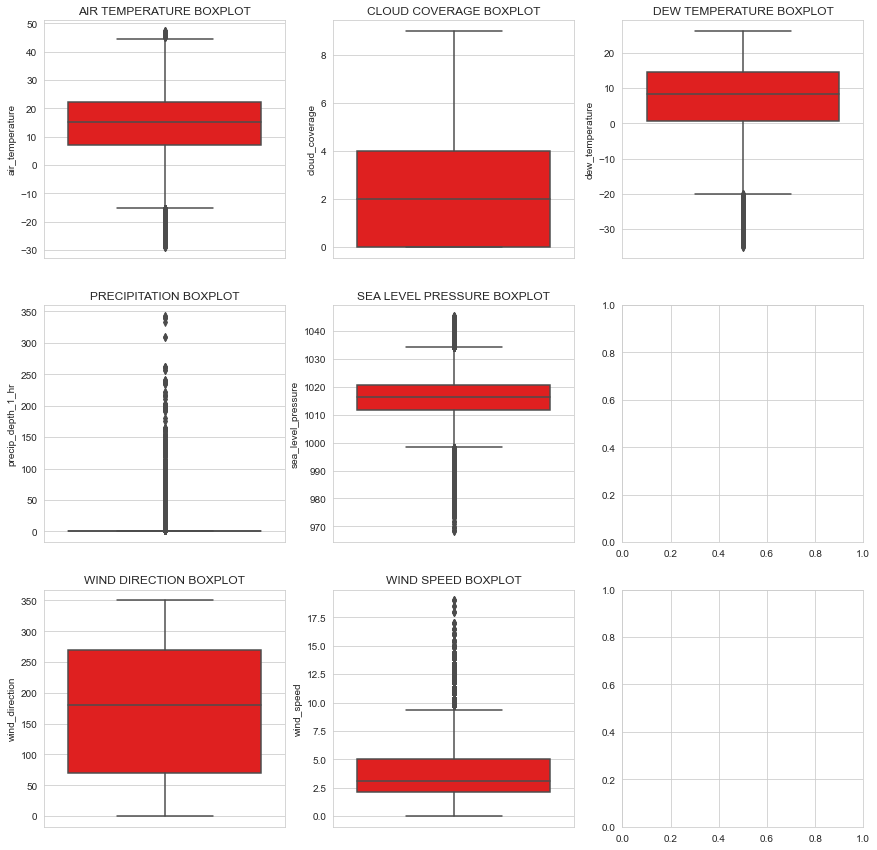

In [32]:
# Create boxplots
fig, axes = plt.subplots(3, 3, figsize=(13, 14))
plt.subplots_adjust(bottom=0.1, right=1, top=0.9)
#plt.subplots_adjust(hspace=0.55);
sb.boxplot(y='air_temperature', data=weather, ax=axes[0][0], color='red')
sb.boxplot(y='cloud_coverage', data=weather, ax=axes[0][1], color='red')
sb.boxplot(y='dew_temperature', data=weather, ax=axes[0][2], color='red')

sb.boxplot(y='precip_depth_1_hr', data=weather, ax=axes[1][0], color='red')
sb.boxplot(y='sea_level_pressure', data=weather, ax=axes[1][1], color='red')

sb.boxplot(y='wind_direction', data=weather, ax=axes[2][0], color='red')
sb.boxplot(y='wind_speed', data=weather, ax=axes[2][1], color='red')

axes[0][0].set_title('AIR TEMPERATURE BOXPLOT')
axes[0][1].set_title('CLOUD COVERAGE BOXPLOT')
axes[0][2].set_title('DEW TEMPERATURE BOXPLOT')

axes[1][0].set_title('PRECIPITATION BOXPLOT')
axes[1][1].set_title('SEA LEVEL PRESSURE BOXPLOT')

axes[2][0].set_title('WIND DIRECTION BOXPLOT')
axes[2][1].set_title('WIND SPEED BOXPLOT');

In [33]:
# Check most extreme values as per boxplots
table = PrettyTable(header_style='upper', padding_width=2, field_names = ["Variable", "Threshold", "Count", "Percentage"])

ct = weather.air_temperature[weather.air_temperature < -20].count()
ttl = weather.air_temperature.count()
pct = round((ct/ttl)*100, 2)
row= "Air temperature", "< -20", ct, pct
table.add_row(row)

ct = weather.dew_temperature[weather.dew_temperature < -30].count()
ttl = weather.dew_temperature.count()
pct = round((ct/ttl)*100, 2)
row= "Dew temperature", "< -30", ct, pct
table.add_row(row)

ct = weather.precip_depth_1_hr[weather.precip_depth_1_hr > 300].count()
ttl = weather.precip_depth_1_hr.count()
pct = round((ct/ttl)*100, 2)
row= "Precipitation", "> 300", ct, pct
table.add_row(row)

ct = weather.sea_level_pressure[weather.sea_level_pressure < 980].count()
ttl = weather.sea_level_pressure.count()
pct = round((ct/ttl)*100, 2)
row= "Sea level pressure", "< 980", ct, pct
table.add_row(row)

ct = weather.wind_speed[weather.wind_speed > 15].count()
ttl = weather.wind_speed.count()
pct = round((ct/ttl)*100, 2)
row= "Wind speed", "> 15", ct, pct
table.add_row(row)

table.align = "r"
print(table)

+----------------------+-------------+---------+--------------+
|            VARIABLE  |  THRESHOLD  |  COUNT  |  PERCENTAGE  |
+----------------------+-------------+---------+--------------+
|     Air temperature  |      < -20  |    298  |        0.21  |
|     Dew temperature  |      < -30  |     65  |        0.05  |
|       Precipitation  |      > 300  |      7  |        0.01  |
|  Sea level pressure  |      < 980  |    130  |         0.1  |
|          Wind speed  |       > 15  |     43  |        0.03  |
+----------------------+-------------+---------+--------------+


In [34]:
# Drop rows with values over threshold
weather.drop(weather.air_temperature[weather.air_temperature < -20].index, inplace = True)
weather.drop(weather.dew_temperature[weather.dew_temperature < -30].index, inplace = True)
weather.drop(weather.precip_depth_1_hr[weather.precip_depth_1_hr > 300].index, inplace = True)
weather.drop(weather.sea_level_pressure[weather.sea_level_pressure < 980].index, inplace = True)
weather.drop(weather.wind_speed[weather.wind_speed > 15].index, inplace = True)

In [35]:
# Run again the previous code to check extreme values deletion
table = PrettyTable(header_style='upper', padding_width=2, field_names = ["Variable", "Threshold", "Count", "Percentage"])

ct = weather.air_temperature[weather.air_temperature < -20].count()
ttl = weather.air_temperature.count()
pct = round((ct/ttl)*100, 2)
row= "Air temperature", "< -20", ct, pct
table.add_row(row)

ct = weather.dew_temperature[weather.dew_temperature < -30].count()
ttl = weather.dew_temperature.count()
pct = round((ct/ttl)*100, 2)
row= "Dew temperature", "< -30", ct, pct
table.add_row(row)

ct = weather.precip_depth_1_hr[weather.precip_depth_1_hr > 300].count()
ttl = weather.precip_depth_1_hr.count()
pct = round((ct/ttl)*100, 2)
row= "Precipitation", "> 300", ct, pct
table.add_row(row)

ct = weather.sea_level_pressure[weather.sea_level_pressure < 980].count()
ttl = weather.sea_level_pressure.count()
pct = round((ct/ttl)*100, 2)
row= "Sea level pressure", "< 980", ct, pct
table.add_row(row)

ct = weather.wind_speed[weather.wind_speed > 15].count()
ttl = weather.wind_speed.count()
pct = round((ct/ttl)*100, 2)
row= "Wind speed", "> 15", ct, pct
table.add_row(row)

table.align = "r"
print(table)

+----------------------+-------------+---------+--------------+
|            VARIABLE  |  THRESHOLD  |  COUNT  |  PERCENTAGE  |
+----------------------+-------------+---------+--------------+
|     Air temperature  |      < -20  |      0  |         0.0  |
|     Dew temperature  |      < -30  |      0  |         0.0  |
|       Precipitation  |      > 300  |      0  |         0.0  |
|  Sea level pressure  |      < 980  |      0  |         0.0  |
|          Wind speed  |       > 15  |      0  |         0.0  |
+----------------------+-------------+---------+--------------+


In [36]:
# After dropping extreme values, we can calculate means to deal with missing values
# Counting again the missing values as we dropped already some rows
Missing(weather)

Amount of missing values:
site_id               0    
timestamp             0    
air_temperature       55   
cloud_coverage        68950
dew_temperature       113  
precip_depth_1_hr     49965
sea_level_pressure    10609
wind_direction        6267 
wind_speed            304  
dtype: int64

Percentage of missing values:
site_id              0.000 
timestamp            0.000 
air_temperature      0.040 
cloud_coverage       49.500
dew_temperature      0.080 
precip_depth_1_hr    35.870
sea_level_pressure   7.620 
wind_direction       4.500 
wind_speed           0.220 
dtype: float64 



In [37]:
# Group the attributes by site_id to provide further clarity on the distribution of the missing values
print("GROUPBY COUNT")
print(weather.groupby('site_id')['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed'].count())
print("\nGROUPBY MEAN")
print(weather.groupby('site_id')['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed'].mean())

GROUPBY COUNT
         air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  wind_speed
site_id                                                                                                                     
0        8776             4954            8776             8778               8694                8529            8779      
1        8748             1701            8748             0                  8697                8746            8749      
2        8780             6427            8780             8715               8737                8190            8776      
3        8774             5137            8772             8741               8620                8625            8774      
4        8781             4553            8779             7464               8708                8676            8781      
5        8746             2725            8746             0                  0                   8453         

In [38]:
# MISSING VALUES REPLACEMENT

# For columns with random missing values, replace with the mean of each attribute grouped by site_id
weather['air_temperature'].fillna(weather.groupby('site_id')['air_temperature'].transform('mean'), inplace=True)
weather['dew_temperature'].fillna(weather.groupby('site_id')['dew_temperature'].transform('mean'), inplace=True)
weather['wind_direction'].fillna(weather.groupby('site_id')['wind_direction'].transform('mean'), inplace=True)
weather['wind_speed'].fillna(weather.groupby('site_id')['wind_speed'].transform('mean'), inplace=True)

# For site_ids where there are no records of a specific attribute
# replace with the mean of all records for that attribute
weather['cloud_coverage'].fillna(weather['cloud_coverage'].mean(), inplace=True)
weather['precip_depth_1_hr'].fillna(weather['precip_depth_1_hr'].mean(), inplace=True)
weather['sea_level_pressure'].fillna(weather['sea_level_pressure'].mean(), inplace=True)

In [39]:
# Check no missing values left:
Missing(weather)

Good news! There are no missing values.


In [40]:
# Finally
print(colored("WEATHER_TRAIN DATAFRAME CLEANED UP", attrs=['bold']))
Descriptives(weather)

WEATHER_TRAIN DATAFRAME CLEANED UP
Looking at the shape to see the number of records:
(139296, 9)

Sampling the first and last rows of data:
   site_id           timestamp  air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  wind_speed
0  0       2016-01-01 00:00:00 25.000           6.000           20.000           1.022              1019.700            0.000           0.000      
1  0       2016-01-01 01:00:00 24.400           2.145           21.100           0.000              1020.200            70.000          1.500      
2  0       2016-01-01 02:00:00 22.800           2.000           21.100           0.000              1020.200            0.000           0.000      
3  0       2016-01-01 03:00:00 21.100           2.000           20.600           0.000              1020.100            0.000           0.000      
4  0       2016-01-01 04:00:00 20.000           2.000           20.000           0.000              1020.000           

In [41]:
del grouped, max, min, table, collist, i, row, ct, ttl, pct
gc.collect()

7312

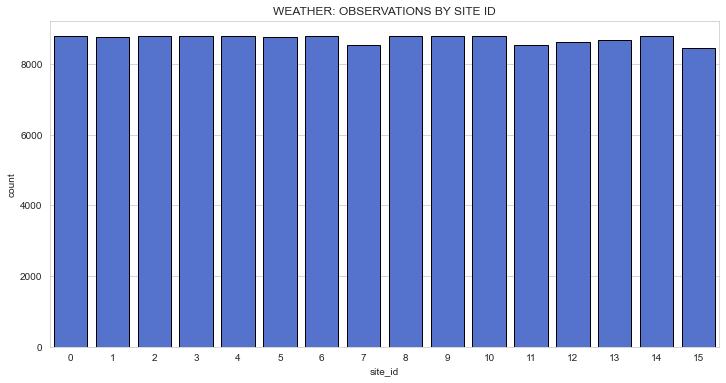

In [42]:
# Create bar plots to see count of observations by site_id and year
                      
fig, axes = plt.subplots(1,1,figsize=(12, 6))

sb.countplot(data=weather, x = 'site_id', color='royalblue',
             edgecolor='black',linewidth=1).set_title('WEATHER: OBSERVATIONS BY SITE ID');

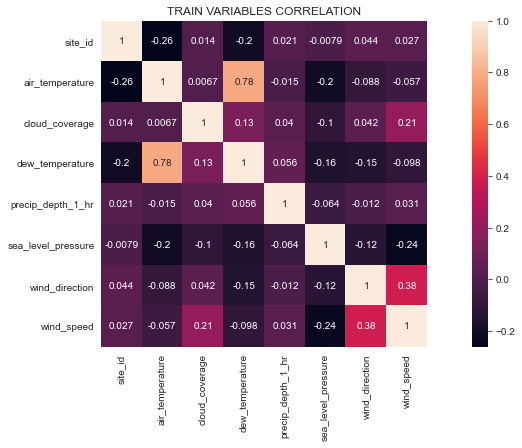

In [43]:
# Correlation check for train
fig, axes = plt.subplots(figsize=(16, 6))
sb.heatmap(weather.corr(), square=True, annot=True).set_title('TRAIN VARIABLES CORRELATION');


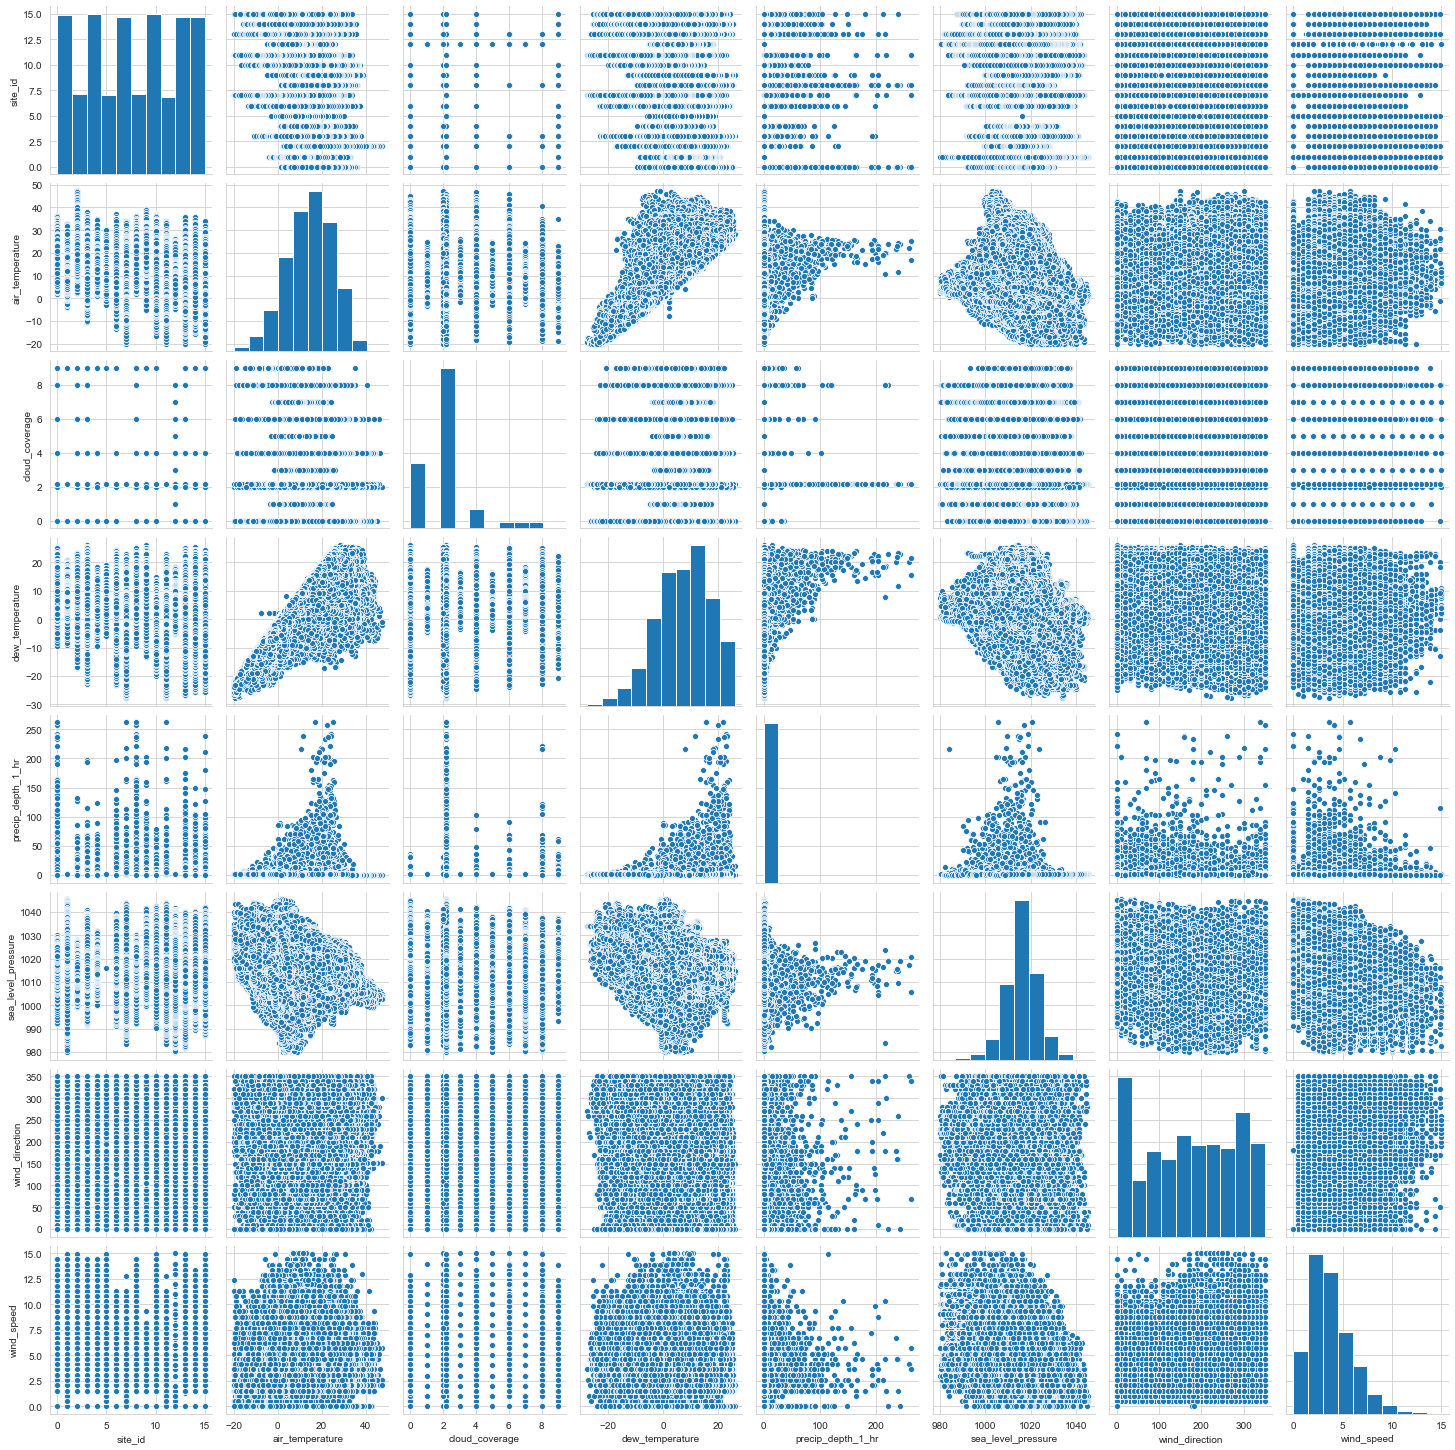

In [44]:
# Found correlation between air and dew temperature
# Plotting pairplot for train to confirm results
sb.pairplot(weather);

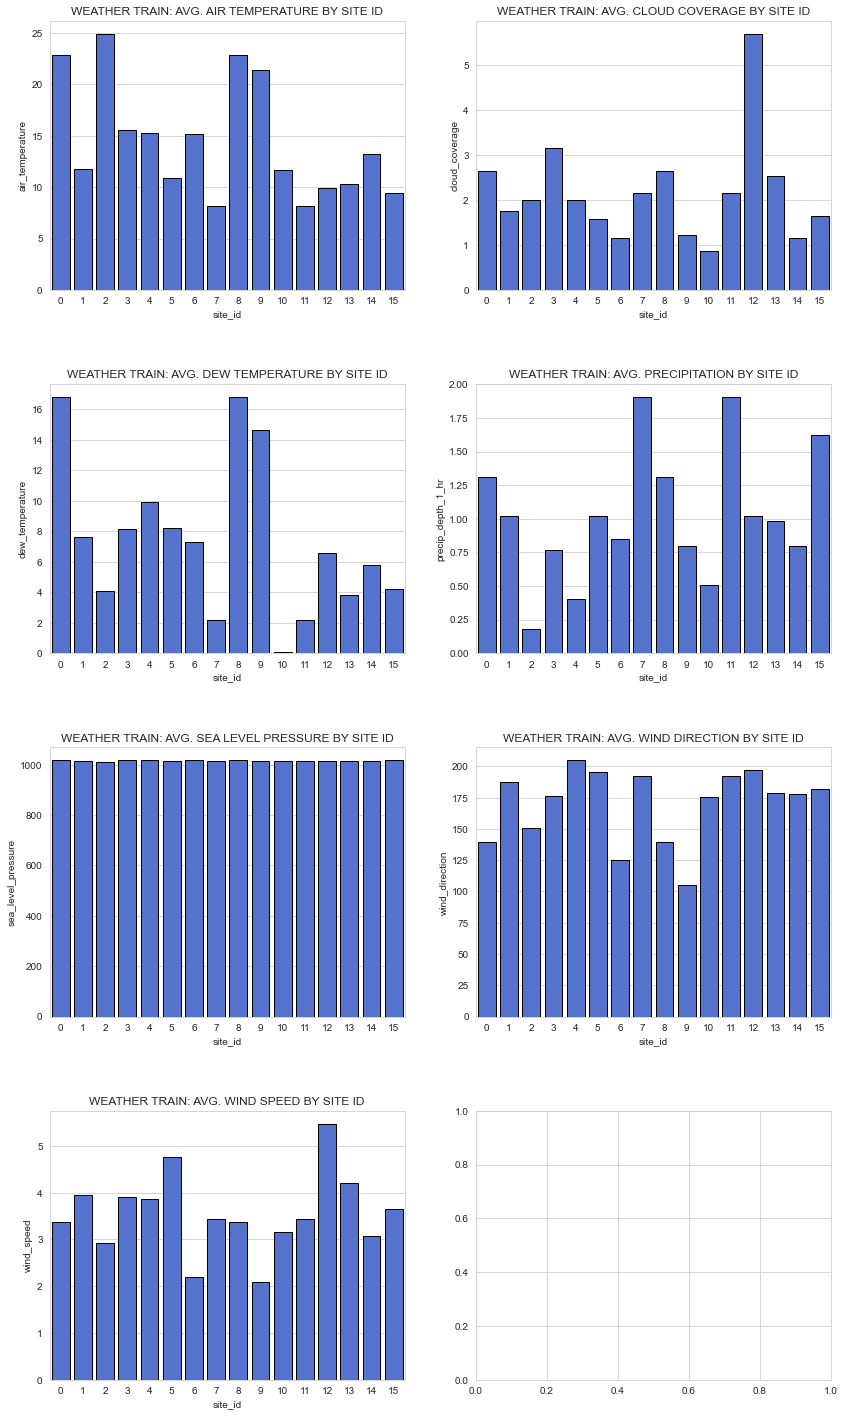

In [45]:
# Create bar plots to see mean of each variable by site_id
# we can observe few differences for site_ids

grouped = weather.groupby('site_id')['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed'].mean()

fig, axes = plt.subplots(4,2,figsize=(14, 25))
plt.subplots_adjust(hspace=0.35);

sb.barplot(data=grouped, x = grouped.index, y = grouped.iloc[:,0], color='royalblue',
            edgecolor = 'black',linewidth=1, ax=axes[0][0]).set_title('WEATHER TRAIN: AVG. AIR TEMPERATURE BY SITE ID')

sb.barplot(data=grouped, x = grouped.index, y = grouped.iloc[:,1], color='royalblue',
            edgecolor = 'black',linewidth=1, ax=axes[0][1]).set_title('WEATHER TRAIN: AVG. CLOUD COVERAGE BY SITE ID')

sb.barplot(data=grouped, x = grouped.index, y = grouped.iloc[:,2], color='royalblue',
            edgecolor = 'black',linewidth=1, ax=axes[1][0]).set_title('WEATHER TRAIN: AVG. DEW TEMPERATURE BY SITE ID')

sb.barplot(data=grouped, x = grouped.index, y = grouped.iloc[:,3], color='royalblue',
            edgecolor = 'black',linewidth=1, ax=axes[1][1]).set_title('WEATHER TRAIN: AVG. PRECIPITATION BY SITE ID')

sb.barplot(data=grouped, x = grouped.index, y = grouped.iloc[:,4], color='royalblue',
            edgecolor = 'black',linewidth=1, ax=axes[2][0]).set_title('WEATHER TRAIN: AVG. SEA LEVEL PRESSURE BY SITE ID')

sb.barplot(data=grouped, x = grouped.index, y = grouped.iloc[:,5], color='royalblue',
            edgecolor = 'black',linewidth=1, ax=axes[2][1]).set_title('WEATHER TRAIN: AVG. WIND DIRECTION BY SITE ID')

sb.barplot(data=grouped, x = grouped.index, y = grouped.iloc[:,6], color='royalblue',
            edgecolor = 'black',linewidth=1, ax=axes[3][0]).set_title('WEATHER TRAIN: AVG. WIND SPEED BY SITE ID');

In [46]:
Text("3/ TRAIN DATAFRAMES PREPROCESSING")

##################################################
3/ TRAIN DATAFRAMES PREPROCESSING
##################################################


In [47]:
# Read the csv file
train = pd.read_csv('train.csv')

In [48]:
# Run basic description of the dataframe
Descriptives(train)

Looking at the shape to see the number of records:
(20216100, 4)

Sampling the first and last rows of data:
   building_id  meter            timestamp  meter_reading
0  0            0      2016-01-01 00:00:00 0.000         
1  1            0      2016-01-01 00:00:00 0.000         
2  2            0      2016-01-01 00:00:00 0.000         
3  3            0      2016-01-01 00:00:00 0.000         
4  4            0      2016-01-01 00:00:00 0.000         
          building_id  meter            timestamp  meter_reading
20216095  1444         0      2016-12-31 23:00:00 8.750         
20216096  1445         0      2016-12-31 23:00:00 4.825         
20216097  1446         0      2016-12-31 23:00:00 0.000         
20216098  1447         0      2016-12-31 23:00:00 159.575       
20216099  1448         0      2016-12-31 23:00:00 2.850         

Description of the file to check values range:
                     count     mean        std   min     25%     50%      75%          max
building_id   2

In [49]:
# Check the memory used by each attribute
MemUsage(train)    

Amount of memory used by each attribute:
Index            128       
building_id      161728800 
meter            161728800 
timestamp        1536423600
meter_reading    161728800 
dtype: int64


2021610128

In [50]:
# Downcast attributes in order to free memory
train["timestamp"] = pd.to_datetime(train["timestamp"])
train['building_id'] = pd.to_numeric(train['building_id'], downcast='unsigned')
train['meter'] = train.meter.astype('uint8')
train['meter_reading'] = pd.to_numeric(train['meter_reading'], downcast='float')

In [51]:
# Re-check memory usage
MemUsage(train)

Amount of memory used by each attribute:
Index            128      
building_id      40432200 
meter            20216100 
timestamp        161728800
meter_reading    80864400 
dtype: int64


303241628

In [52]:
# Check the missing values
Missing(train)

Good news! There are no missing values.


In [53]:
# Check for outliers
grouped = train.groupby('timestamp')

max = grouped.max().max()
min = grouped.min().min()

table = PrettyTable(header_style='upper', padding_width=2, field_names = ["", "max", "min"])

for i in ['building_id', 'meter',  'meter_reading']:
    row= i, round(max[i],1), round(min[i],1)
    table.add_row(row)
table.align = "r"
print(table)

+-----------------+--------------+-------+
|                 |         MAX  |  MIN  |
+-----------------+--------------+-------+
|    building_id  |      1448.0  |  0.0  |
|          meter  |         3.0  |  0.0  |
|  meter_reading  |  21904700.0  |  0.0  |
+-----------------+--------------+-------+


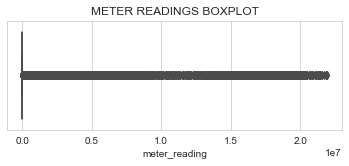

In [54]:
rcParams['figure.figsize'] = 6, 2
sb.boxplot('meter_reading', data=train, color='red').set_title('METER READINGS BOXPLOT')
plt.show();

9.3% of the meter readings are equal to 0.


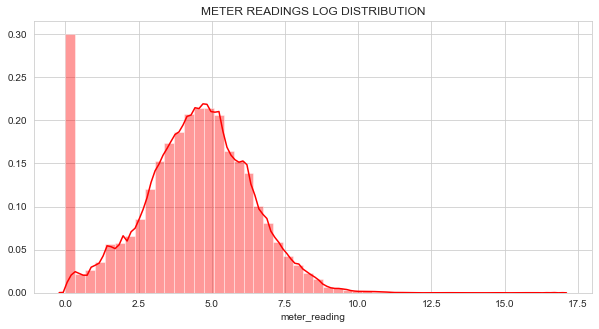

In [55]:
# Boxplot doesn't help as there are many 0 values recorded.
Pct = round(train.meter_reading[train.meter_reading == 0].count() / train.meter_reading.count()*100,1)
print("{}% of the meter readings are equal to 0.".format(Pct))

rcParams['figure.figsize'] = 10, 5
sb.distplot(np.log1p(train['meter_reading']), color='red').set_title('METER READINGS LOG DISTRIBUTION');

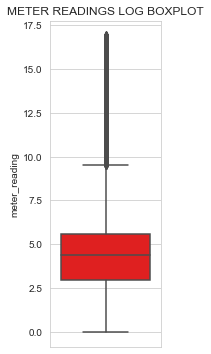

In [56]:
# Run boxplot with log values
rcParams['figure.figsize'] = 2, 6
sb.boxplot(y=np.log1p(train['meter_reading']), data=train, color='red').set_title('METER READINGS LOG BOXPLOT')
plt.show();

In [57]:
x = np.log1p(train['meter_reading'])
print("There are {} values beyond upper whisker".format(x[x>9.5].count()))

There are 66212 values beyond upper whisker


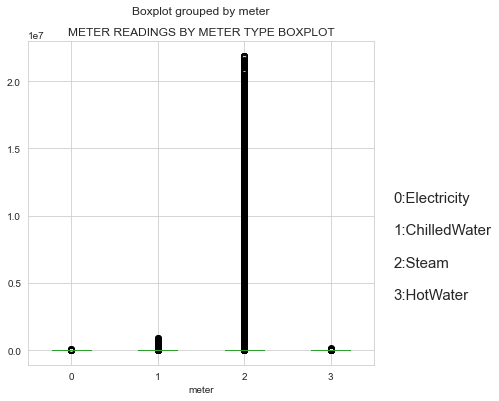

In [58]:
# --> boxplot by meter type
rcParams['figure.figsize'] = 6, 6
train.boxplot(column=['meter_reading'], by='meter').set_title('METER READINGS BY METER TYPE BOXPLOT')
plt.annotate('0:Electricity\n\n1:ChilledWater\n\n2:Steam\n\n3:HotWater', xy=(1, 1), xytext=(20, -150), va='top',
             xycoords='axes fraction', textcoords='offset points', fontsize = 15);

#### As per Boxplot, there might be an issue with meter type 2
#### as meter readings being the target variable no action is taken and further checks will be carried out later

In [59]:
# Finally
print(colored("TRAIN DATAFRAME CLEANED UP", attrs=['bold']))
Descriptives(train)

TRAIN DATAFRAME CLEANED UP
Looking at the shape to see the number of records:
(20216100, 4)

Sampling the first and last rows of data:
   building_id  meter  timestamp  meter_reading
0  0            0     2016-01-01 0.000         
1  1            0     2016-01-01 0.000         
2  2            0     2016-01-01 0.000         
3  3            0     2016-01-01 0.000         
4  4            0     2016-01-01 0.000         
          building_id  meter           timestamp  meter_reading
20216095  1444         0     2016-12-31 23:00:00 8.750         
20216096  1445         0     2016-12-31 23:00:00 4.825         
20216097  1446         0     2016-12-31 23:00:00 0.000         
20216098  1447         0     2016-12-31 23:00:00 159.575       
20216099  1448         0     2016-12-31 23:00:00 2.850         

Description of the file to check values range:
                     count     mean        std   min     25%     50%      75%          max
building_id   20216100.000 799.278  426.913    0.000 3

In [60]:
del grouped, max, min, table, i, row
gc.collect()

15034

In [61]:
Text("4/ MERGING FILES TO CREATE FINAL DATASET")

##################################################
4/ MERGING FILES TO CREATE FINAL DATASET
##################################################


In [62]:
# MERGING THE FILES TO SET THE FINAL TRAIN DATA SET TO USE FOR ANALYSIS
train = train.merge(building, on='building_id', how='left')
train = train.merge(weather, on=['site_id', 'timestamp'], how='left')

In [63]:
del building, weather
gc.collect()

60

In [64]:
Missing(train)

Amount of missing values:
building_id           0     
meter                 0     
timestamp             0     
meter_reading         0     
site_id               594303
primary_use           594303
square_feet           594303
air_temperature       730482
cloud_coverage        730482
dew_temperature       730482
precip_depth_1_hr     730482
sea_level_pressure    730482
wind_direction        730482
wind_speed            730482
dtype: int64

Percentage of missing values:
building_id          0.000
meter                0.000
timestamp            0.000
meter_reading        0.000
site_id              2.940
primary_use          2.940
square_feet          2.940
air_temperature      3.610
cloud_coverage       3.610
dew_temperature      3.610
precip_depth_1_hr    3.610
sea_level_pressure   3.610
wind_direction       3.610
wind_speed           3.610
dtype: float64 



In [65]:
# Drop records that did not match
train.dropna(axis=0, how='any', inplace=True)
Missing(train)
train.shape

Good news! There are no missing values.


(19485618, 14)

In [66]:
# Reorder the variables
train = train[[
'site_id',
'building_id',
'meter',
'timestamp',
'primary_use',
'square_feet',
'air_temperature',
'cloud_coverage',
'dew_temperature',
'precip_depth_1_hr',
'sea_level_pressure',
'wind_direction',
'wind_speed',
'meter_reading']]

In [67]:
Descriptives(train)

Looking at the shape to see the number of records:
(19485618, 14)

Sampling the first and last rows of data:
   site_id  building_id  meter  timestamp primary_use  square_feet  air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  wind_speed  meter_reading
0 0.000     0            0     2016-01-01  Education  7432.000     25.000           6.000           20.000           1.022              1019.700            0.000           0.000       0.000         
1 0.000     1            0     2016-01-01  Education  2720.000     25.000           6.000           20.000           1.022              1019.700            0.000           0.000       0.000         
2 0.000     2            0     2016-01-01  Education  5376.000     25.000           6.000           20.000           1.022              1019.700            0.000           0.000       0.000         
3 0.000     3            0     2016-01-01  Education  23685.000    25.000           6.000      

In [68]:
# Cast again site_id to int
train['site_id'] = pd.to_numeric(train['site_id'], downcast='unsigned')

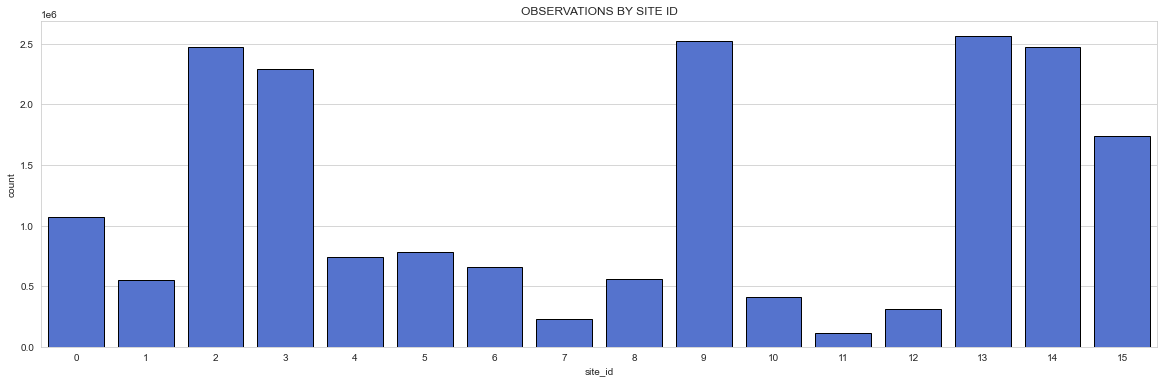

In [69]:
# Create bar plots to see count of observations by site_id
                      
fig, axes = plt.subplots(figsize=(20, 6))

sb.countplot(data=train, x='site_id', color='royalblue',edgecolor='black',
             linewidth=1).set_title('OBSERVATIONS BY SITE ID');


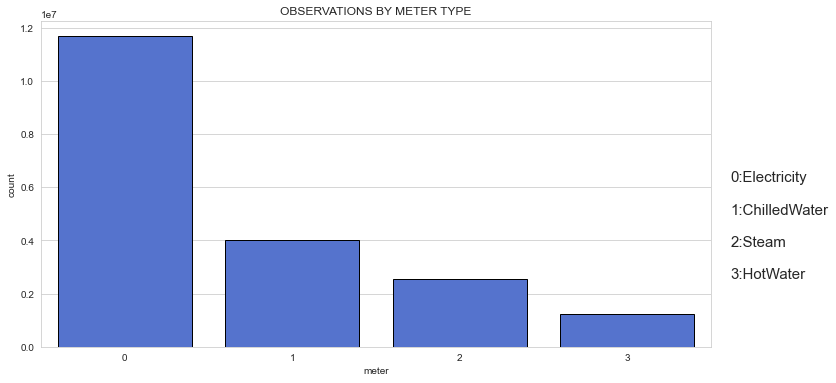

In [70]:
# Create bar plots to see count of observations by meter type
# Will see it is very close; a few less records in train as we drop NA rows
fig, axes = plt.subplots(figsize=(12, 6))

sb.countplot(data=train, x='meter', color='royalblue',
             edgecolor='black',linewidth=1).set_title('OBSERVATIONS BY METER TYPE')

plt.annotate('0:Electricity\n\n1:ChilledWater\n\n2:Steam\n\n3:HotWater', xy=(1, 1), xytext=(20, -150), va='top',
             xycoords='axes fraction', textcoords='offset points', fontsize = 15);

In [71]:
Text("/ TARGET VARIABLE: METER READINGS ANALYSIS")

##################################################
/ TARGET VARIABLE: METER READINGS ANALYSIS
##################################################


Pearsons correlation: 0.034


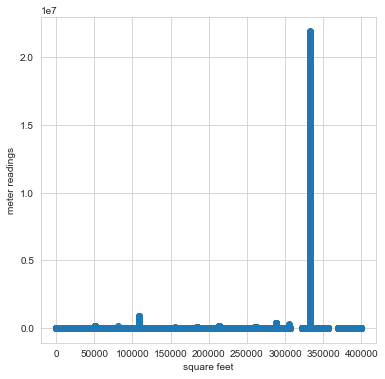

In [72]:
# Interesting to see there is no correlation between square_feet and meter_reading
# -->size independent of consumption

# calculate Pearson's correlation
corr, _ = pearsonr(train['square_feet'], train['meter_reading'])
print('Pearsons correlation: %.3f' % corr)

# plot correlation
pyplot.scatter(train['square_feet'], train['meter_reading'])
plt.xlabel('square feet')
plt.ylabel('meter readings');

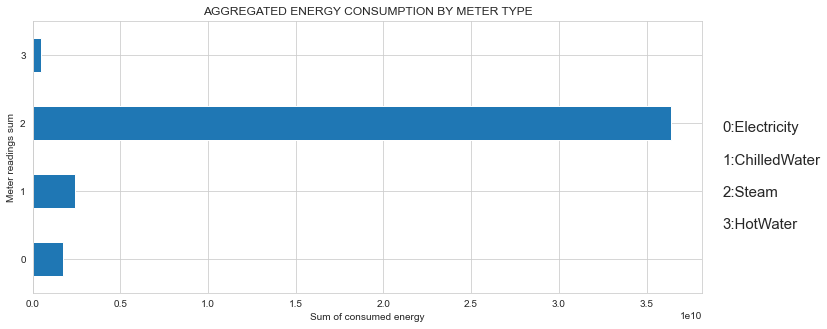

In [73]:
plt.figure(figsize=(12,5))
train.groupby("meter").meter_reading.sum().plot(kind="barh")
plt.title("AGGREGATED ENERGY CONSUMPTION BY METER TYPE")
plt.xlabel("Sum of consumed energy")
plt.ylabel("Meter readings sum")
plt.annotate('0:Electricity\n\n1:ChilledWater\n\n2:Steam\n\n3:HotWater', xy=(1, 1), xytext=(20, -100), va='top',
             xycoords='axes fraction', textcoords='offset points', fontsize = 15);

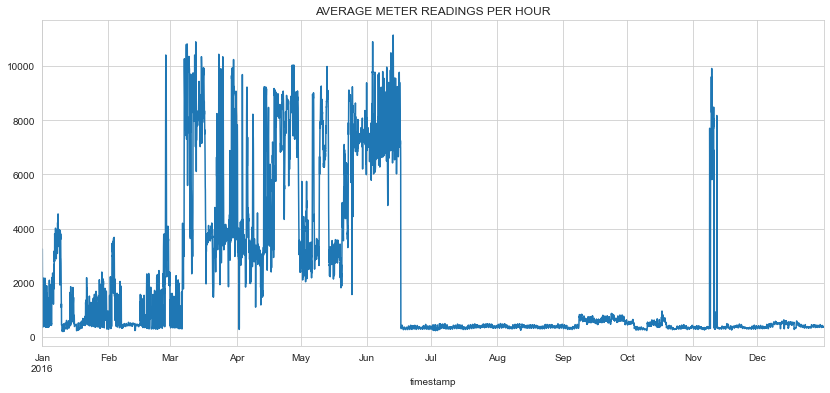

In [74]:
# Plotting meter readings
fig, axes = plt.subplots(figsize=(14, 6))
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot()
axes.set_title('AVERAGE METER READINGS PER HOUR');

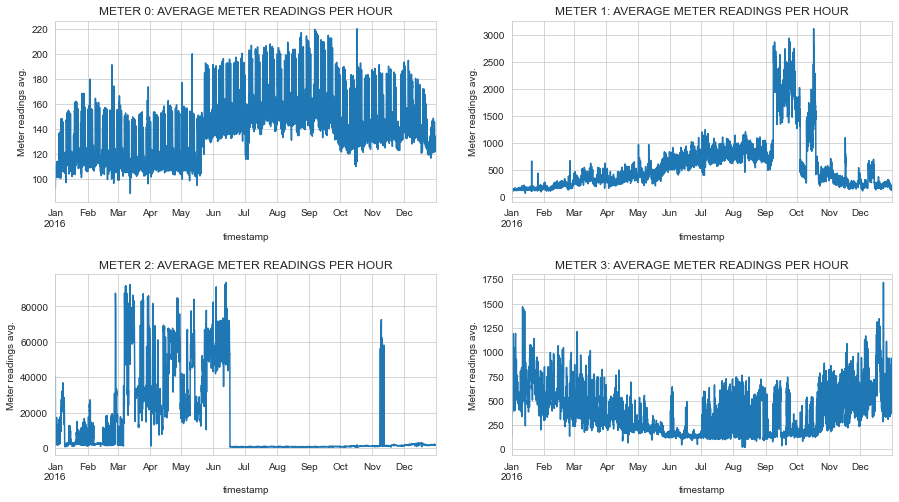

In [75]:
# Plotting meter readings by meter type
# Will notice meter type 2 readings look wrong
fig, axes = plt.subplots(2,2, figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

train0 = train[train.meter == 0]
train1 = train[train.meter == 1]
train2 = train[train.meter == 2]
train3 = train[train.meter == 3]

train0[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading']\
.plot(ax=axes[0][0]).set_ylabel('Meter readings avg.')
train1[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading']\
.plot(ax=axes[0][1]).set_ylabel('Meter readings avg.')
train2[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading']\
.plot(ax=axes[1][0]).set_ylabel('Meter readings avg.')
train3[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading']\
.plot(ax=axes[1][1]).set_ylabel('Meter readings avg.')

axes[0][0].set_title('METER 0: AVERAGE METER READINGS PER HOUR')
axes[0][1].set_title('METER 1: AVERAGE METER READINGS PER HOUR')
axes[1][0].set_title('METER 2: AVERAGE METER READINGS PER HOUR')
axes[1][1].set_title('METER 3: AVERAGE METER READINGS PER HOUR');


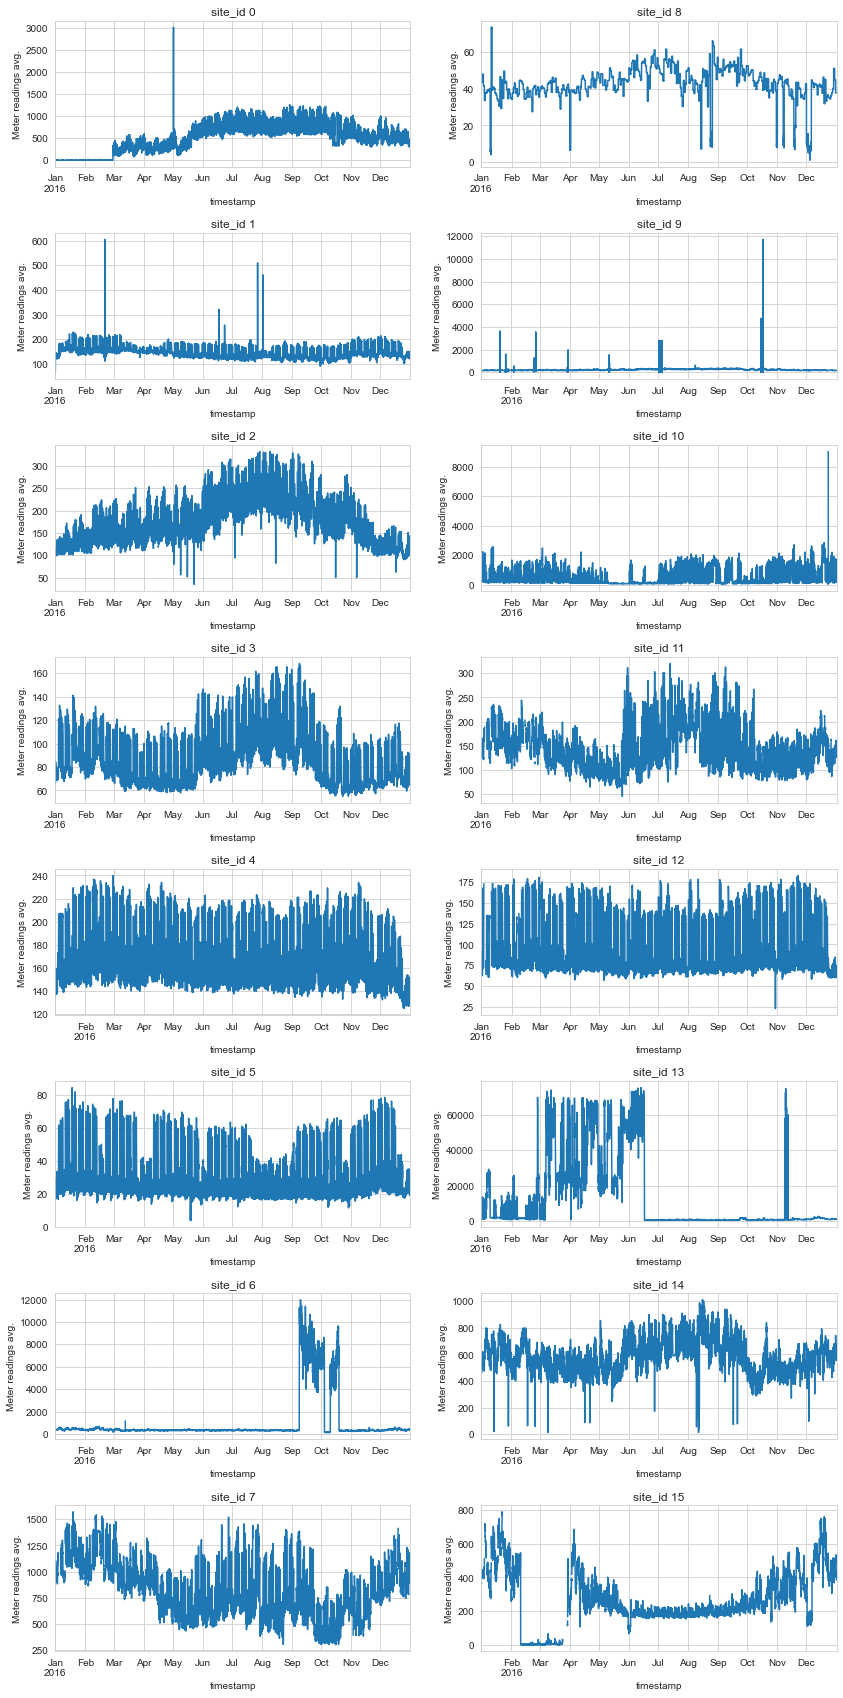

In [76]:
# Plotting meter readings by site_id
fig, axes = plt.subplots(8,2,figsize=(14, 30))
plt.subplots_adjust(hspace=0.45);
for i in range(train['site_id'].nunique()):
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading']\
    .plot(ax=axes[i%8][i//8]).set_ylabel('Meter readings avg.')
    axes[i%8][i//8].set_title('site_id {}'.format(i))
    
plt.show();


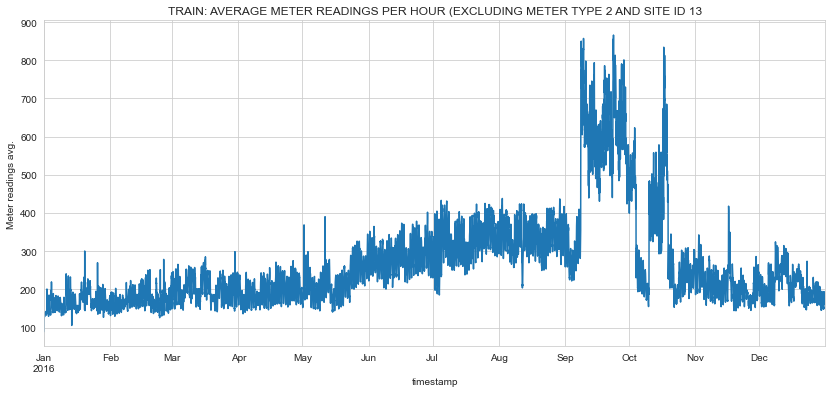

In [77]:
# Plotting meter readings without type 2 and site_id 13
trainX = (train[(train.meter != 2) & (train.meter != 13)])

fig, axes = plt.subplots(figsize=(14, 6))

trainX[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading']\
.plot().set_ylabel('Meter readings avg.')

axes.set_title('TRAIN: AVERAGE METER READINGS PER HOUR (EXCLUDING METER TYPE 2 AND SITE ID 13');

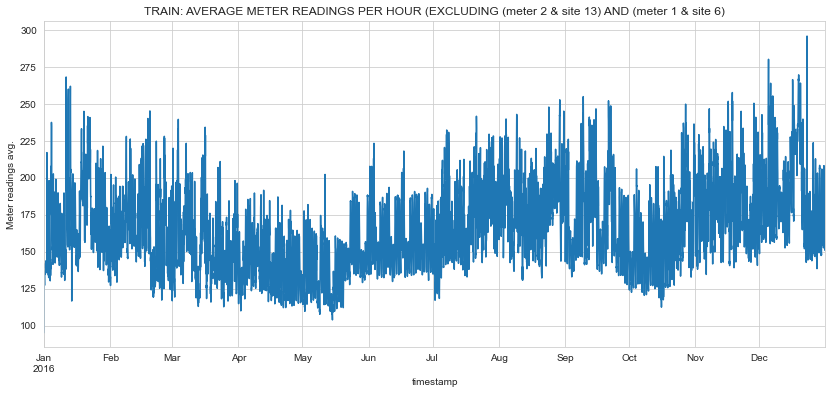

In [78]:
# Now similar to the previous for meter type 1 and site id 6
# Plotting meter readings without type 1/2 and site_id 6/13
trainX = (trainX[(trainX.meter != 1) & (trainX.meter != 6)])

fig, axes = plt.subplots(figsize=(14, 6))

trainX[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading']\
.plot().set_ylabel('Meter readings avg.')

axes.set_title('TRAIN: AVERAGE METER READINGS PER HOUR (EXCLUDING (meter 2 & site 13) AND (meter 1 & site 6)');

In [79]:
# This plot looks much nicer!
# Upper in winter and summer and lower in spring and autumn
# As a conclusion we can say that there are buildings (maybe not all of them) that would bias the model
# on condition: (meter 2 & site 13) OR (meter 1 & site 6)